In [72]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [73]:
class_full_name_list = ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
class_short_name_list = ['General', 'Paper', 'Pack', 'Metal', 'Glass', 'Plastic', 'Foam', 'Bag', 'Battery', 'Cloth']
class_color_list = [
    [250,0,50], 
    [0, 255, 0], 
    [0, 180, 80], 
    [185, 185, 185], 
    [100, 100, 100], 
    [200, 50, 150], 
    [50, 150, 200], 
    [50, 200, 150], 
    [200, 200, 200], 
    [255,255,255], 
]
class_color_list = [(np.array(RGB)/255).tolist() for RGB in class_color_list]
boxform = [{'boxstyle': 'round', 'ec': RGB, 'fc': RGB, 'alpha': 1} for RGB in class_color_list] # 'fc': np.clip(np.array(RGB)*10, 0., 1.)

In [123]:
def show_bbox_image(image_id, PredictionString, ax=None, thr=0.5, image_path='/opt/ml/detection/dataset/', text_label=True, image_label=True):
    flag = ax
    if not flag:
        fig, ax = plt.subplots(figsize=(12, 13))

    image = cv2.imread(os.path.join(image_path, image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)#.astype(np.float32)
    ax.imshow(image)

    bboxes = PredictionString.split(' ')
    # bboxes = list(map(float, bboxes))

    ax.set_title(f"total : {len(bboxes)//6} labels", fontsize=24)
    ax.axis('off')

    for idx in range(len(bboxes)//6):
        label, score, x_min, y_min, x_max, y_max = bboxes[6*idx:6*idx+6]
        label, score, x_min, y_min, x_max, y_max = int(label), float(score), float(x_min), float(y_min), float(x_max), float(y_max)
        
        if score < thr: continue
        
        if text_label:
            print(f"{class_full_name_list[label]:>15} : {score:.3f}")
        
        rect = patches.Rectangle(
                (x_min, y_min),
                x_max-x_min,
                y_max-y_min,
                edgecolor = class_color_list[label],
                fill=False,
        ) 
        ax.add_patch(rect)

        if image_label:
            box = boxform[label]
            # box['alpha'] = 1-score
            box['alpha'] = score
            ax.text(x_min, y_min, f'{class_full_name_list[label]}\n{score:.3f}', fontsize=16, horizontalalignment='left', verticalalignment='bottom', bbox=boxform[label])
    
    if not flag:
        plt.show()


  General trash : 0.194
          Paper : 0.928
     Paper pack : 0.090
      Styrofoam : 0.061


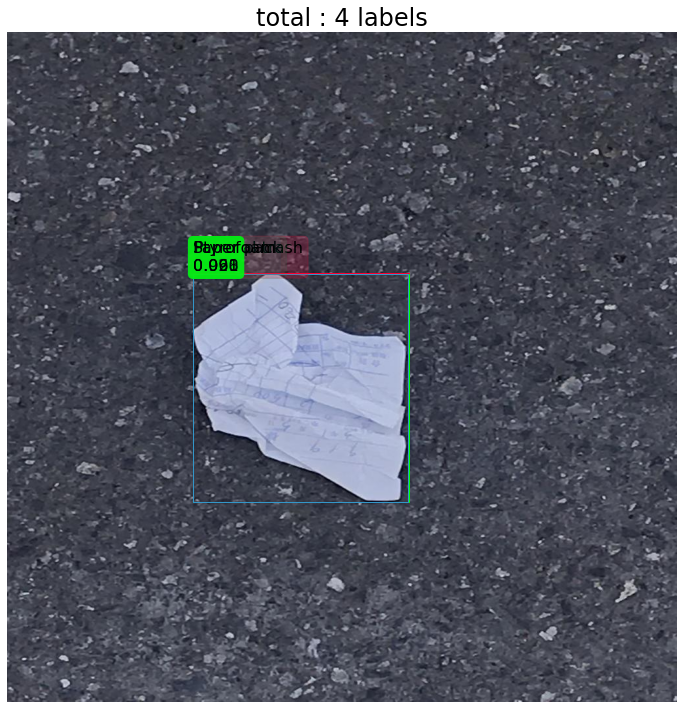

In [124]:
# single view
csv_path = '/opt/ml/detection/utils/ensemble_models/output/ensenble0.618.csv'
df = pd.read_csv(csv_path)

rand_index = np.random.randint(0,len(df),10)

index = [ 541, 4087, 4717, 3614, 3891, 4090, 1466, 2409, 2866, 3258]
for PredictionString, image_id in df.iloc[[580]].values:
    show_bbox_image(image_id, PredictionString, thr=0)

In [125]:
(dfs[1]['image_id'] == 'test/4087.jpg').all()

False

In [126]:
dfs[1][dfs[1]['image_id'] == 'test/4087.jpg']

PredictionString       image_id
4075  7 0.977665 272.999424 241.00044799999995 769.9...  test/4087.jpg

selected filenames : ['ensenble0.618.csv', 'yolo50.469.csv', 'deformable_detr.csv']
selected index : [541, 4087, 4717, 3614, 3891, 4090, 1466, 2409, 2866, 3258]


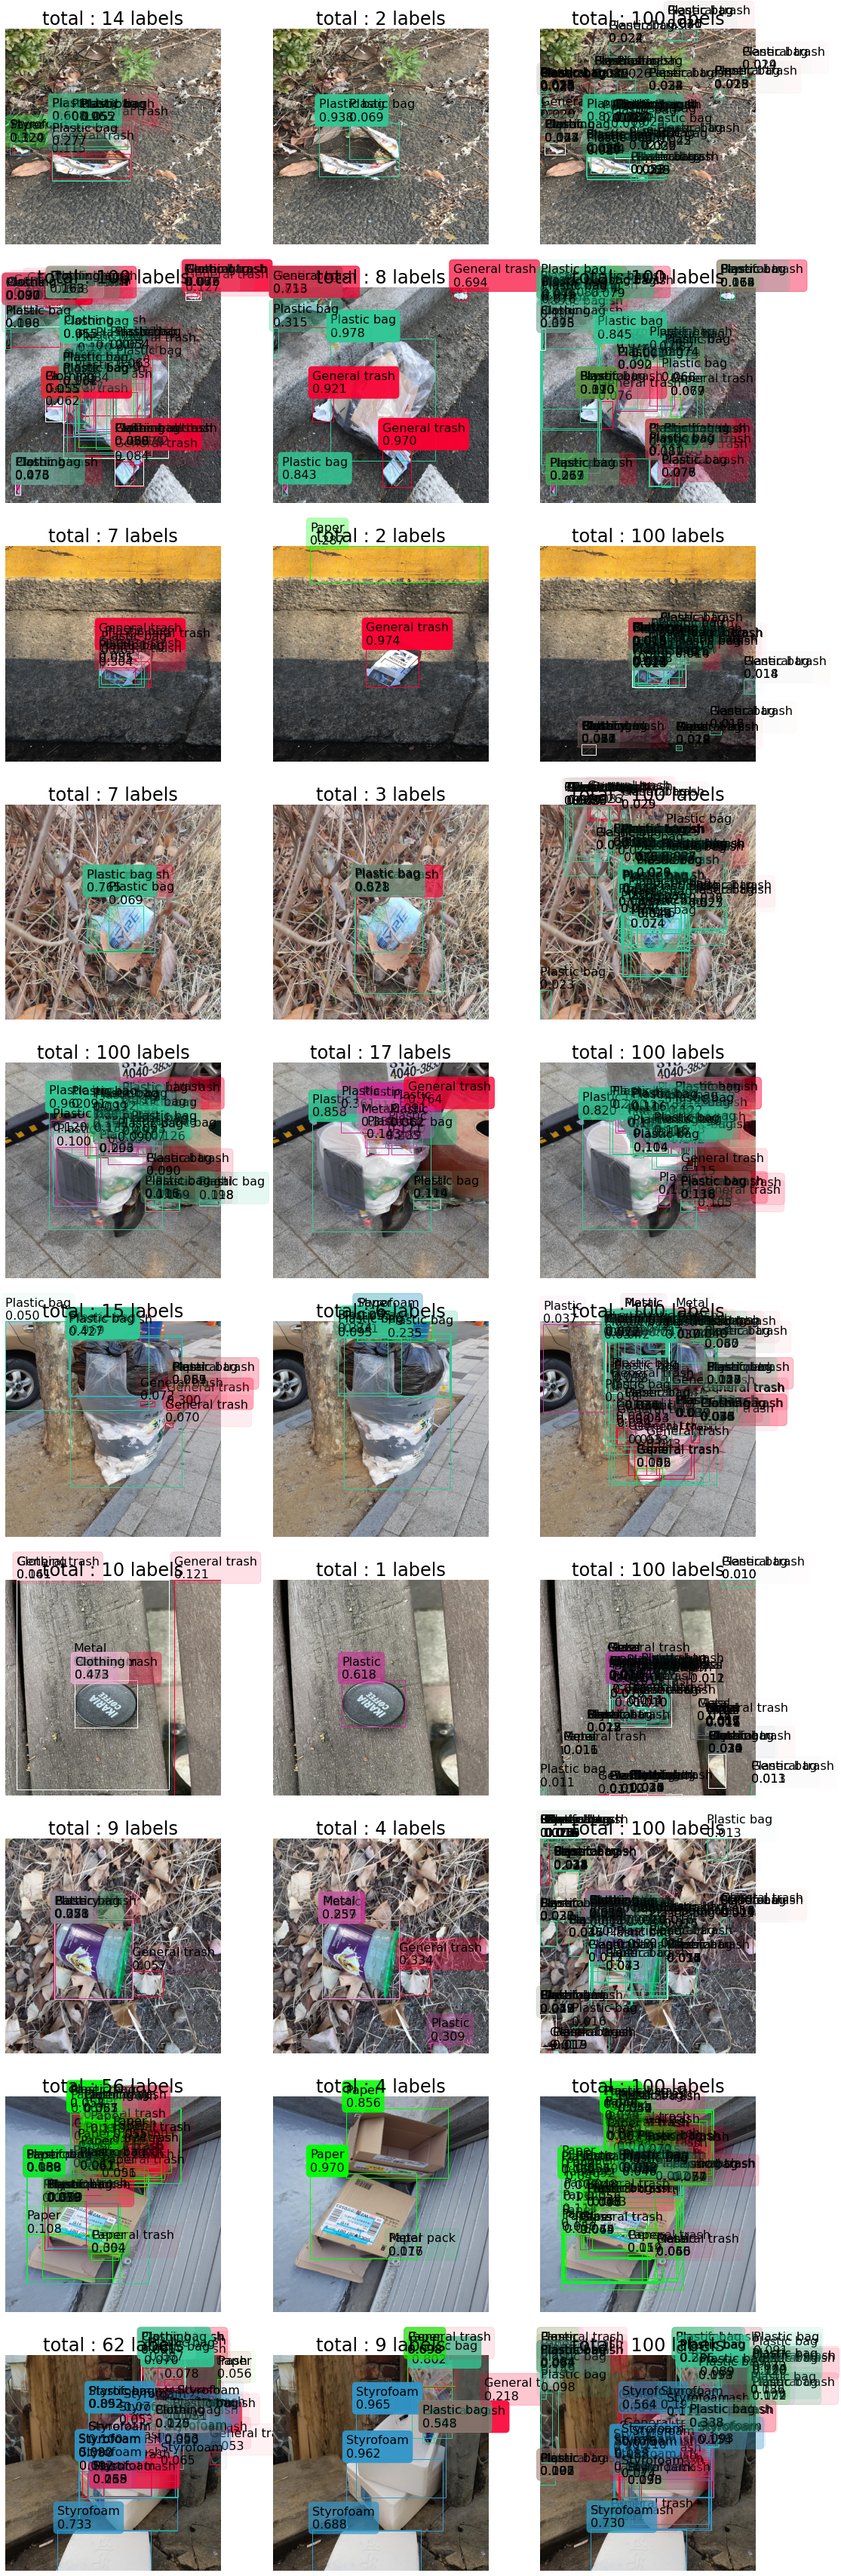

In [127]:
# multi view
csv_path = ['/opt/ml/detection/utils/ensemble_models/output/ensenble0.618.csv', 
            '/opt/ml/detection/utils/ensemble_models/yolo50.469.csv', 
            '/opt/ml/detection/utils/ensemble_models/deformable_detr.csv']


filenames = []
dfs = []
for path in csv_path:
    dfs.append(pd.read_csv(path))
    filenames.append(os.path.basename(path))

rand_index = np.random.randint(0,len(dfs[0]),10)
index = [ 541, 4087, 4717, 3614, 3891, 4090, 1466, 2409, 2866, 3258]

print(f"selected filenames : {filenames}")
print(f"selected index : {index}")

view_size = 8
fig, axes = plt.subplots(len(index), len(csv_path), sharex=True, sharey=True, figsize=(view_size*len(csv_path), view_size*len(index)+2))
for row, idx in enumerate(index):
    for col, df in enumerate(dfs):
        condition = df['image_id'] == f'test/{idx:0>4d}.jpg'

        if condition.any():
            image_info = df[condition].values
            if len(image_info) > 1:
                print("submission has too many row in same id")

            PredictionString, image_id = image_info[0]
            show_bbox_image(image_id, PredictionString, thr=0, ax=axes[row,col], text_label=False, image_label=False)
plt.show()